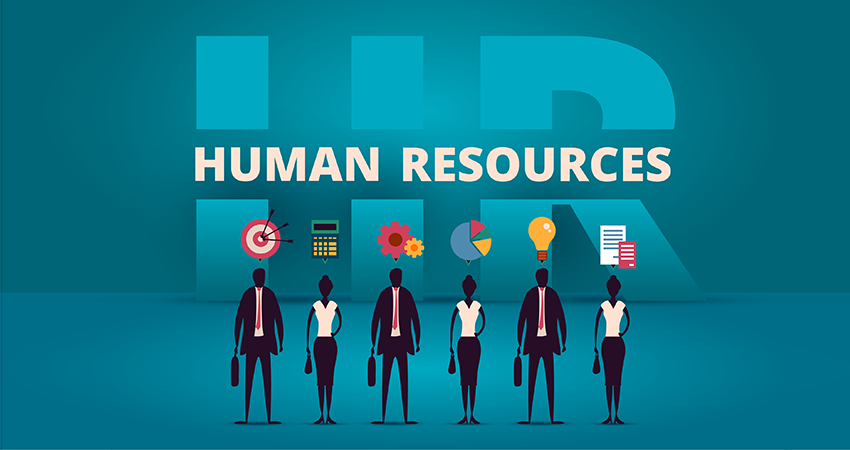

# **Problem Statement**

The HR Department of this SOFTWARE company wants to try a new initiative to retain their employees.
To apply this new initiatives they need to predict the likelyhood of employees who may want to leave

**Current Challenges-**

Currently they can only know the reasons during “exit interview” by then it is too late to put efforts to retian them

**Appraoch to solve this problem**

They have shared a Data set of past employees that has details of employees Left or still EMployed

We need to build a Model based on past data to classify Employee's probability to stay or leave

# **Data Description**

---

The Business Intelligence Analysts of the Company has provided three datasets
that contain information about past employees and their status (still employed or already left)

**department_data**
  This dataset contains information about each department. The schema of the dataset is as follows:

    dept_id - Unique Department Code
    dept_name - Name of the Department
    dept_head -  Name of the Head of the Department

**employee_details_data**
This dataset consists of Employee ID, their Age, Gender and Marital Status. The schema of this dataset is as follows:

    employee_id -  Unique ID Number for each employee
    age - Age of the employee
    gender - Gender of the employee
    marital_status - Marital Status of the employee

**employee_data**
This dataset consists of each employee’s Administrative Information, Workload Information, Mutual Evaluation Information and Status.

  **Target variable**

    status - Current employment status (Employed / Left)


** Administrative information**

    department - Department to which the employees belong(ed) to
    salary - Salary level with respect to rest of their department
    tenure - Number of years at the company
    recently_promoted - Was the employee promoted in the last 3 years?
    employee_id - Unique ID Number for each employee

**Workload information**

    n_projects - Number of projects the employee has worked on
    avg_monthly_hrs - Average number of hours worked per month

**Mutual evaluation information**

    satisfaction - Score for employee’s satisfaction with the company (higher is better)
    last_evaluation - Score for most recent evaluation of employee (higher is better)
    filed_complaint - Has the employee filed a formal complaint in the last 3 years?

**Importing list of Libraries required for this project**

In [2]:
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

**Fetching the input Data set from the Mysql DB**

Data connection credentials are given

In [3]:
pip install mysql-connector-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 19.8 MB/s eta 0:00:00


In [4]:
import mysql.connector
import csv
mydb = mysql.connector.connect(
  host=	'cpanel.insaid.co',
  user=	'student',
  passwd=	'student',
  database=	'Capstone2'
)

Reading mqsql Tables and joining them to prepare the required Data set (Data frame)

In [5]:
query1 = """
    SELECT t1.*,t2.*
    FROM department_data t1
    INNER JOIN employee_data t2 ON t1.dept_id = t2.department
    INNER JOIN employee_details_data t3 ON t2.employee_id = t3.employee_id
"""
# query2 = "SELECT * FROM employee_data"
# query3 = "SELECT * FROM employee_details_data"

# reading data into a DataFrame called hr
hr = pd.read_sql(query1, mydb)

<ipython-input-5-faf799995796>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hr = pd.read_sql(query1, mydb)


In [169]:
# Visual inspection of dataframe
hr.head()

,dept_id,dept_name,dept_head,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id
0,D00-PD,Product,Darcy Staines,291.0,D00-PD,NaN,0.885668,6,NaN,low,0.157136,Left,4.0,108147
1,D00-ENG,Engineering,Sushant Raghunathan K,189.0,D00-ENG,NaN,NaN,4,NaN,low,0.202714,Employed,2.0,115820
2,D00-SS,Sales,Edward J Bayley,259.0,D00-SS,NaN,0.627583,5,NaN,low,0.762133,Employed,3.0,106011
3,D00-ENG,Engineering,Sushant Raghunathan K,271.0,D00-ENG,NaN,0.946384,5,NaN,low,0.934184,Left,5.0,121359
4,D00-ENG,Engineering,Sushant Raghunathan K,128.0,D00-ENG,NaN,0.500299,2,NaN,medium,0.471927,Left,3.0,111129


In [ ]:
# Checking Null values and datatypes
hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13232 entries, 0 to 13231
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dept_id            13232 non-null  object 
 1   dept_name          13232 non-null  object 
 2   dept_head          13232 non-null  object 
 3   avg_monthly_hrs    13232 non-null  float64
 4   department         13232 non-null  object 
 5   filed_complaint    1920 non-null   float64
 6   last_evaluation    11833 non-null  float64
 7   n_projects         13232 non-null  int64  
 8   recently_promoted  277 non-null    float64
 9   salary             13232 non-null  object 
 10  satisfaction       13082 non-null  float64
 11  status             13232 non-null  object 
 12  tenure             13082 non-null  float64
 13  employee_id        13232 non-null  int64  
dtypes: float64(6), int64(2), object(6)
memory usage: 1.4+ MB


**Some of the visible Challenges in the given data set**

1. dept_id & department are same - drop 'department'
2. filed_complaint and recently_promoted has more NULL values - fillna with 0

In [18]:
hr = hr.drop(['department'], axis=1)
hr = hr.fillna(int(0))

In [181]:
hr

,dept_id,dept_name,dept_head,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id
0,D00-PD,Product,Darcy Staines,291.0,0.0,0.885668,6,0.0,low,0.157136,Left,4.0,108147
1,D00-ENG,Engineering,Sushant Raghunathan K,189.0,0.0,0.000000,4,0.0,low,0.202714,Employed,2.0,115820
2,D00-SS,Sales,Edward J Bayley,259.0,0.0,0.627583,5,0.0,low,0.762133,Employed,3.0,106011
3,D00-ENG,Engineering,Sushant Raghunathan K,271.0,0.0,0.946384,5,0.0,low,0.934184,Left,5.0,121359
4,D00-ENG,Engineering,Sushant Raghunathan K,128.0,0.0,0.500299,2,0.0,medium,0.471927,Left,3.0,111129
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13227,D00-FN,Finance,Aanchal J,193.0,0.0,0.990808,4,0.0,low,0.695128,Employed,3.0,112337
13228,D00-SS,Sales,Edward J Bayley,179.0,0.0,0.809153,4,0.0,medium,0.831582,Employed,3.0,110651
13229,D00-ENG,Engineering,Sushant Raghunathan K,262.0,0.0,0.961219,5,0.0,low,0.853951,Left,5.0,108344
13230,D00-SP,Support,Amelia Westray,216.0,0.0,0.820489,5,0.0,medium,0.132267,Employed,4.0,108200


In [120]:
valuecounts = hr['recently_promoted'].value_counts()
print(valuecounts)

1.0    277
Name: recently_promoted, dtype: int64


In [188]:
hr.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure,employee_id
count,13232.000000,13232.000000,13232.000000,13232.000000,13232.000000,13232.000000,13232.000000,13232.000000
mean,200.013830,0.145103,0.642546,3.782799,0.020934,0.615089,3.469619,112114.316883
std,50.907572,0.352218,0.274907,1.251219,0.143169,0.257674,1.517185,8498.801360
min,49.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,100101.000000
25%,155.000000,0.000000,0.522072,3.000000,0.000000,0.442808,3.000000,105774.750000
50%,199.000000,0.000000,0.683030,4.000000,0.000000,0.650209,3.000000,111291.500000
75%,245.000000,0.000000,0.856696,5.000000,0.000000,0.823931,4.000000,116641.500000
max,310.000000,1.000000,1.000000,7.000000,1.000000,1.000000,10.000000,148988.000000


# **Exploratory Data Analysis (EDA) to get some critical DATA insights**

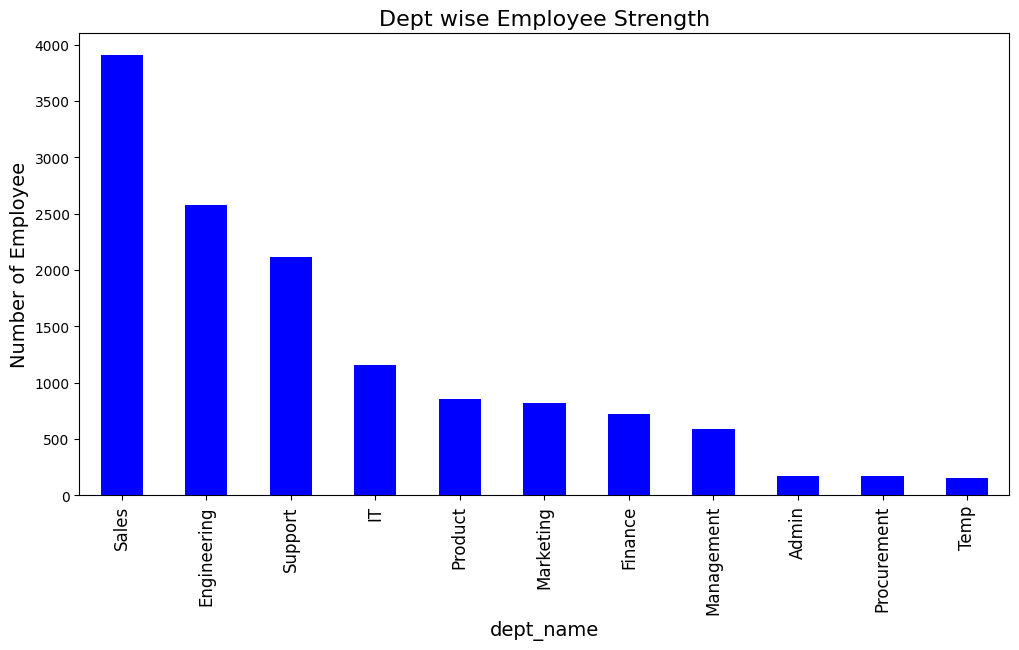

In [195]:
plt.figure(figsize = [12,6])
hr['dept_name'].value_counts().plot.bar(color = 'blue')
plt.xlabel('dept_name', size = 14)
plt.ylabel('Number of Employee', size = 14)
plt.title('Dept wise Employee Strength', size = 16)
plt.xticks(size = 12)
plt.show()

<Figure size 1200x600 with 0 Axes>

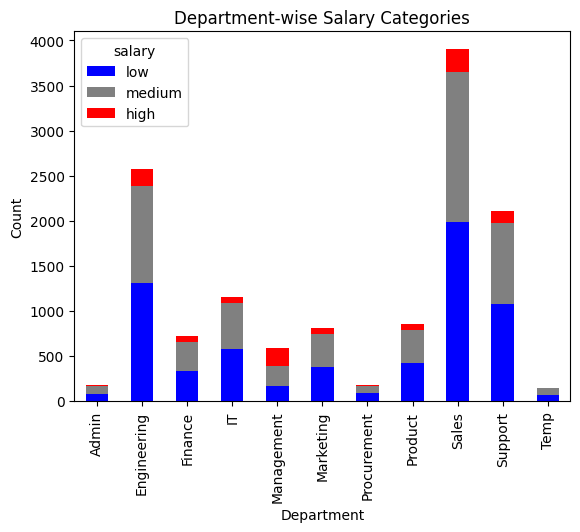

In [198]:
plt.figure(figsize = [12,6])
grouped = hr.groupby(['dept_name', 'salary']).size().unstack(fill_value=0)
grouped = grouped[['low', 'medium', 'high']]
grouped.plot(kind='bar', stacked=True, color=['blue', 'grey', 'red'])
plt.xlabel('Department')
plt.ylabel('Count')
plt.title('Department-wise Salary Categories')
plt.show()

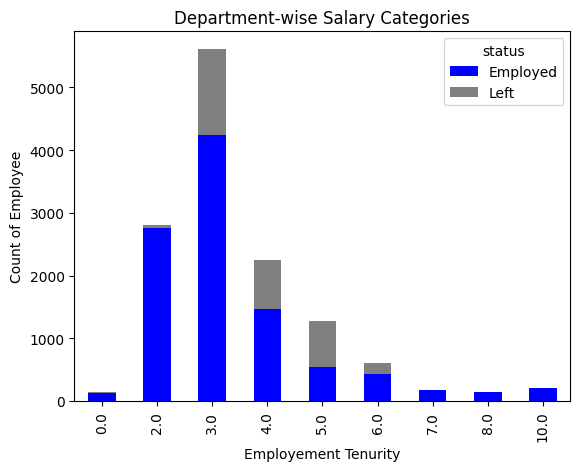

In [199]:
grouped = hr.groupby(['tenure', 'status']).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True, color=['blue', 'grey'])
plt.xlabel('Employement Tenurity')
plt.ylabel('Count of Employee')
plt.title('Department-wise Salary Categories')
plt.show()

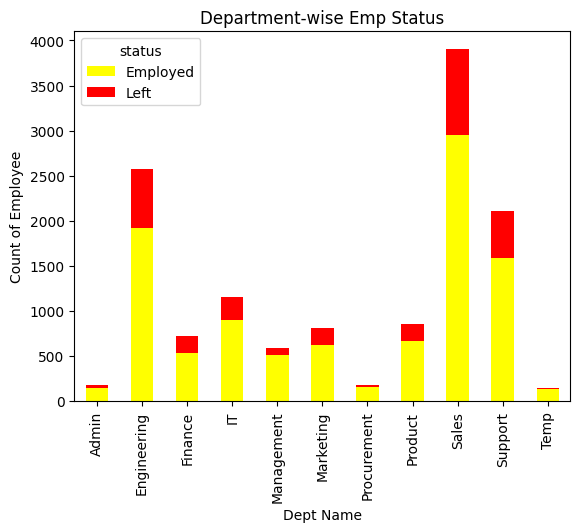

In [64]:
grouped = hr.groupby(['dept_name', 'status']).size().unstack(fill_value=0)

# Plotting
grouped.plot(kind='bar', stacked=True, color=['yellow', 'red'])

# Adding labels and title
plt.xlabel('Dept Name')
plt.ylabel('Count of Employee')
plt.title('Department-wise Emp Status')

# Displaying the plot
plt.show()

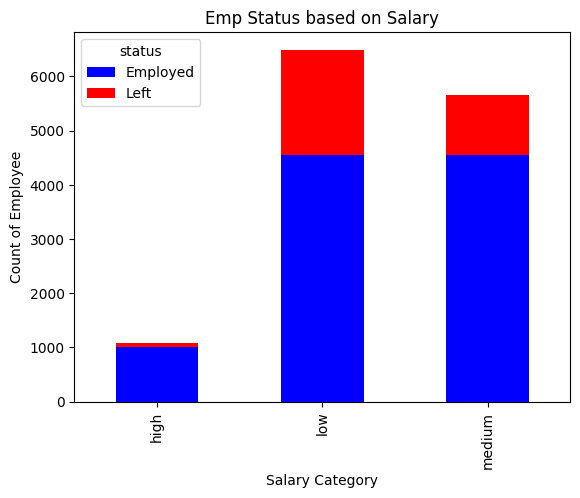

In [201]:
grouped = hr.groupby(['salary', 'status']).size().unstack(fill_value=0)

# Plotting
grouped.plot(kind='bar', stacked=True, color=['blue', 'red'])

# Adding labels and title
plt.xlabel('Salary Category')
plt.ylabel('Count of Employee')
plt.title('Emp Status based on Salary')

# Displaying the plot
plt.show()

In [20]:
hr.head()

,dept_id,dept_name,dept_head,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id
0,D00-PD,Product,Darcy Staines,291.0,0.0,0.885668,6,0.0,low,0.157136,Left,4.0,108147
1,D00-ENG,Engineering,Sushant Raghunathan K,189.0,0.0,0.000000,4,0.0,low,0.202714,Employed,2.0,115820
2,D00-SS,Sales,Edward J Bayley,259.0,0.0,0.627583,5,0.0,low,0.762133,Employed,3.0,106011
3,D00-ENG,Engineering,Sushant Raghunathan K,271.0,0.0,0.946384,5,0.0,low,0.934184,Left,5.0,121359
4,D00-ENG,Engineering,Sushant Raghunathan K,128.0,0.0,0.500299,2,0.0,medium,0.471927,Left,3.0,111129


In [19]:
#correlation Matrix
correlation_matrix = hr.corr()
correlation_matrix

<ipython-input-19-e60c93b18981>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = hr.corr()


,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure,employee_id
avg_monthly_hrs,1.000000,-0.009685,0.290909,0.436407,-0.000299,0.032473,0.166132,0.010434
filed_complaint,-0.009685,1.000000,-0.022417,-0.006170,0.040178,0.052028,0.006977,-0.031546
last_evaluation,0.290909,-0.022417,1.000000,0.309013,-0.004224,0.070004,0.271168,0.017859
n_projects,0.436407,-0.006170,0.309013,1.000000,-0.002884,-0.091274,0.223901,0.007068
recently_promoted,-0.000299,0.040178,-0.004224,-0.002884,1.000000,0.030838,0.065038,-0.025566
satisfaction,0.032473,0.052028,0.070004,-0.091274,0.030838,1.000000,-0.023190,-0.079206
tenure,0.166132,0.006977,0.271168,0.223901,0.065038,-0.023190,1.000000,0.003584
employee_id,0.010434,-0.031546,0.017859,0.007068,-0.025566,-0.079206,0.003584,1.000000


**Data Inferences**

There are some interesting insights in the data set that we have, and this data story will help us to dissect the  data into meaningful insights

- There are total 13232 Employee's details
- There are 11 departments, Maximum employees are in **Sales Department**
- Sales, Engineering and Support departments have higher ratio of employees who are in **Low Salary** category
- Maximum employees have **left** whos **Tenurity** is between 3 to 5 years, and 5 years tenurity has highest ratio of employees who have left
- Most number of employees have **left** from Engineering, Sales and Support
- Most employees have **left** from **Low Salary** category






# **Data Preprocessing for Model**

We need to drop columns that is not adding value
There are Features that do not influence the outcome such as;
1. dept_id
2. dept_head
2. department

Attributes that has more NaN values;
1. filed_complaint
2. recently_promoted




In [ ]:
hr.head()

In [44]:
# Dropping columns that are not influencing the target variable
columns_drop = ['dept_id', 'dept_head','recently_promoted','filed_complaint','dept_name']
hr1 = hr.drop(columns_drop, axis=1)
hr1['status'] = hr1['status'].replace('Left', 1)
hr1['status'] = hr1['status'].replace('Employed', 0)


In [45]:
# lable encoding for Salary since there are 3 categories
label_encoder = LabelEncoder()
hr1['salary'] = label_encoder.fit_transform(hr1['salary'])


In [46]:
#correlation Matrix
correlation_matrix = hr1.corr()
correlation_matrix

,avg_monthly_hrs,last_evaluation,n_projects,salary,satisfaction,status,tenure,employee_id
avg_monthly_hrs,1.000000,0.290909,0.436407,0.005099,0.032473,0.080945,0.166132,0.010434
last_evaluation,0.290909,1.000000,0.309013,0.031281,0.070004,0.076192,0.271168,0.017859
n_projects,0.436407,0.309013,1.000000,0.009117,-0.091274,0.033961,0.223901,0.007068
salary,0.005099,0.031281,0.009117,1.000000,0.015162,-0.010627,-0.008979,-0.000494
satisfaction,0.032473,0.070004,-0.091274,0.015162,1.000000,-0.365099,-0.023190,-0.079206
status,0.080945,0.076192,0.033961,-0.010627,-0.365099,1.000000,0.139504,0.220214
tenure,0.166132,0.271168,0.223901,-0.008979,-0.023190,0.139504,1.000000,0.003584
employee_id,0.010434,0.017859,0.007068,-0.000494,-0.079206,0.220214,0.003584,1.000000


**Preparing for Test and Train data**

In [47]:
# Separating Target variable
X = hr1.drop('status', axis=1)
y = hr1['status']

In [48]:
# Splitting Data into Test and Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=134)

# #Model Selection
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=123)
gb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = gb_classifier.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.971666037023045
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2000
           1       0.96      0.92      0.94       647

    accuracy                           0.97      2647
   macro avg       0.97      0.96      0.96      2647
weighted avg       0.97      0.97      0.97      2647



In [37]:
confusion_matrix(y_test, y_pred)

array([[ 598,   49],
       [  26, 1974]])

# **Importing *UNSEEN* data for predcition**

In [49]:
# Reading unseen data
X_unseen = pd.read_excel('/content/GCD_Capstone_Project_unseen_data.xlsx')

**Preparing Unseen data for MODEL Prediction**
Dropping fields those are not part of Train Data set

In [50]:
columns_drop = [ 'department','recently_promoted','filed_complaint']
X_unseen.drop(columns=columns_drop, inplace=True)

X_unseen = X_unseen.fillna(0)
label_encoder = LabelEncoder()
X_unseen['salary'] = label_encoder.fit_transform(X_unseen['salary'])


In [41]:
X_unseen

,avg_monthly_hrs,last_evaluation,n_projects,salary,satisfaction,tenure,employee_id
0,134,0.528841,2,1,0.400464,3.0,119045
1,221,0.784561,2,1,0.759513,3.0,112223
2,156,0.545183,2,2,0.336457,3.0,103924
3,133,0.000000,4,2,0.832039,2.0,105922
4,135,0.454637,2,1,0.320723,5.0,103297
...,...,...,...,...,...,...,...
95,261,0.748131,4,0,0.762597,3.0,116666
96,231,0.663618,3,1,0.660827,2.0,106422
97,162,0.509361,4,1,0.885543,3.0,107889
98,209,0.565951,3,1,0.601487,3.0,117622


In [52]:
# Pass unseen data to the model for prediction of leaving (employed - 0, leave - 1)
y_pred_unseen = gb_classifier.predict_proba(X_unseen)[:, 1]
print("Prediction Prob:", y_pred_unseen)


Prediction Prob: [0.95363102 0.05029103 0.87491158 0.00825642 0.72271604 0.01439422
 0.15736432 0.02635213 0.00987548 0.01282557 0.00175946 0.99800946
 0.83353437 0.01149256 0.01146767 0.0097804  0.94093498 0.00387312
 0.00919517 0.01792179 0.90117096 0.90919909 0.02479236 0.01925749
 0.89885696 0.00833872 0.01372996 0.00825642 0.99840648 0.01152761
 0.00847589 0.01112829 0.01076766 0.01874879 0.01170469 0.00630555
 0.04752964 0.96364446 0.00934788 0.03982942 0.99043128 0.98280334
 0.00611662 0.0329512  0.01022596 0.05049045 0.82035111 0.00654903
 0.01070614 0.03003513 0.01046547 0.00785162 0.01120059 0.00690897
 0.04992193 0.00737516 0.01259578 0.01120588 0.00368719 0.9985754
 0.23444411 0.89377689 0.88190634 0.00990906 0.96945054 0.68577303
 0.01084652 0.99740981 0.0044723  0.87436721 0.01651257 0.00676595
 0.01041445 0.17128621 0.9082914  0.3414971  0.01677678 0.0062169
 0.02637399 0.00522122 0.97325901 0.93790043 0.07382859 0.78884138
 0.01313468 0.00727717 0.00521469 0.00631487 0.

In [206]:
y_pred_unseen.shape

(100,)

**Preparing OUTPUT file for submission**
- Column 1 Employee id from Unseen Data
- Column 2 corresponding Predicted Target outcome (Status)
- No Index column and Header
- submission file in csv format

In [53]:
unseen_pred = pd.DataFrame(X_unseen['employee_id'])
unseen_pred['pred'] = y_pred_unseen
#unseen_pred.to_csv('submission.csv', index=False, header=False)
unseen_pred.to_csv('submission.csv', index=False, header=False)